In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
df_train = pd.read_csv('train.csv')

In [ ]:
df_train["LotShape"]

0       Reg
1       Reg
2       IR1
3       IR1
4       IR1
       ... 
1455    Reg
1456    Reg
1457    Reg
1458    Reg
1459    Reg
Name: LotShape, Length: 1460, dtype: object

## Missing data

In [ ]:
df_missing = df_train.isnull().sum()
df_missing = df_missing.sort_values(ascending=False)

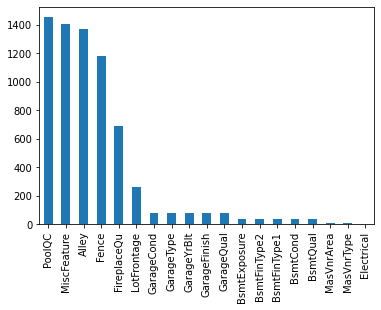

In [ ]:
df_missing[df_missing > 0].plot.bar()

In [ ]:
# missing data가 있는 feature 제거
df_missing = df_missing[df_missing > 0]
df_train = df_train.drop(df_missing.index.tolist(), axis=1)

In [ ]:
# missing data가 있는지 재확인
df_train.isnull().sum().max()

0

In [ ]:
numeric = [f for f in df_train.columns if df_train.dtypes[f] != 'object'] # 숫자형
numeric.remove('Id')
numeric.remove('SalePrice')

categorical = [f for f in df_train.columns if df_train.dtypes[f] == 'object'] # 분류형

## Preprocess categorical data

In [ ]:
category_maps = []
def add_rank_feature (feature_name, rank_feature_name):
  df_order = pd.DataFrame()
  df_order['val'] = df_train[feature_name].unique()
  df_order.index = df_order.val

  df_order['mean_price'] = df_train[[feature_name, 'SalePrice']].groupby(feature_name).mean()['SalePrice']
  df_order['rank'] = range(1, len(df_order) + 1)
  df_order = df_order['rank'].to_dict()

  category_maps.append(df_order)

  df_train[rank_feature_name] = df_train.apply(lambda x: df_order[x[feature_name]], axis=1)

In [ ]:
rank_features = []
for feature_name in categorical:
  rank_feature_name = feature_name + '_rank'

  print(feature_name, '-->', rank_feature_name)

  add_rank_feature(feature_name, rank_feature_name)
  rank_features.append(rank_feature_name)

MSZoning --> MSZoning_rank
Street --> Street_rank
LotShape --> LotShape_rank
LandContour --> LandContour_rank
Utilities --> Utilities_rank
LotConfig --> LotConfig_rank
LandSlope --> LandSlope_rank
Neighborhood --> Neighborhood_rank
Condition1 --> Condition1_rank
Condition2 --> Condition2_rank
BldgType --> BldgType_rank
HouseStyle --> HouseStyle_rank
RoofStyle --> RoofStyle_rank
RoofMatl --> RoofMatl_rank
Exterior1st --> Exterior1st_rank
Exterior2nd --> Exterior2nd_rank
ExterQual --> ExterQual_rank
ExterCond --> ExterCond_rank
Foundation --> Foundation_rank
Heating --> Heating_rank
HeatingQC --> HeatingQC_rank
CentralAir --> CentralAir_rank
KitchenQual --> KitchenQual_rank
Functional --> Functional_rank
PavedDrive --> PavedDrive_rank
SaleType --> SaleType_rank
SaleCondition --> SaleCondition_rank


In [ ]:
df_processed = df_train[rank_features + numeric]

In [ ]:
df_processed['SalePrice'] = df_train['SalePrice']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_processed

,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterQual_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,1,1,1,1,1,2,1,2,2,1,1,2,1,1,2,2,2,1,2,1,1,1,2,1,1,1,1,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007,181500
2,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,223500
3,1,1,2,1,1,3,1,3,1,1,1,1,1,1,3,3,2,1,3,1,2,1,1,1,1,1,2,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006,140000
4,1,1,2,1,1,2,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1,1,1,1,1,1,1,18,1,1,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,1,1,60,7917,6,5,1999,2000,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,2,460,0,40,0,0,0,0,0,8,2007,175000
1456,1,1,1,1,1,1,1,7,1,1,1,2,1,1,8,5,2,1,2,1,3,1,2,2,1,1,1,20,13175,6,6,1978,1988,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,2,500,349,0,0,0,0,0,0,2,2010,210000
1457,1,1,1,1,1,1,1,3,1,1,1,1,1,1,7,7,3,2,6,1,1,1,1,1,1,1,1,70,9042,7,9,1941,2006,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1,252,0,60,0,0,0,0,2500,5,2010,266500
1458,1,1,1,1,1,1,1,12,1,1,1,2,2,1,2,2,2,1,2,1,2,1,1,1,1,1,1,20,9717,5,6,1950,1996,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1,240,366,0,112,0,0,0,0,4,2010,142125


In [ ]:
corrmat = df_processed.corr()

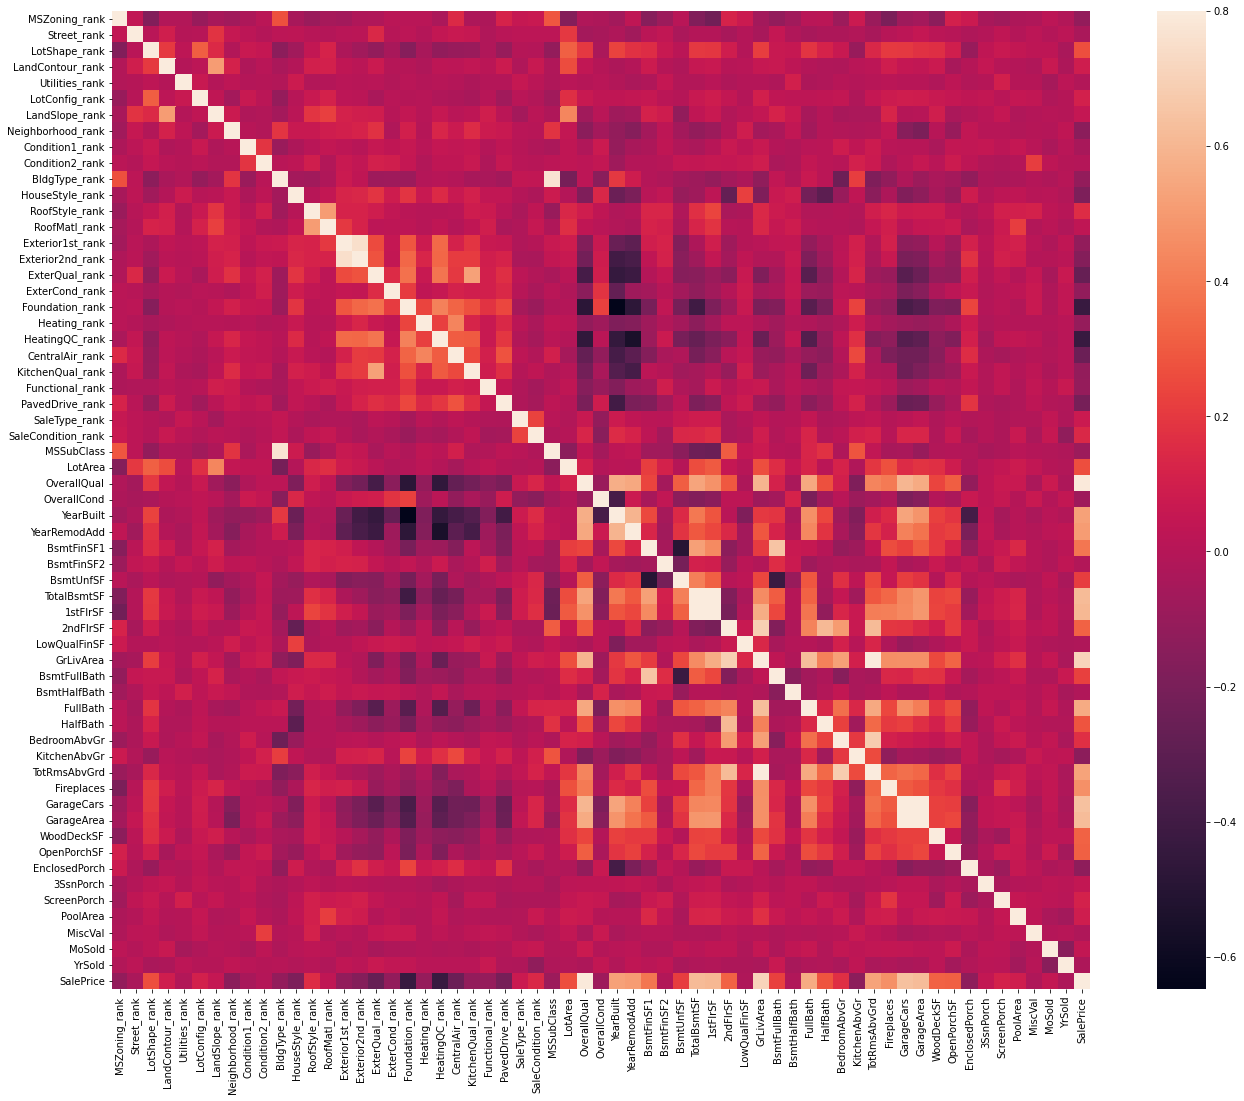

In [ ]:
f, ax = plt.subplots(figsize=(24, 18))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
df_features = corrmat.sort_values(by=['SalePrice'])['SalePrice']

In [ ]:
df_features[:-1]

Foundation_rank      -0.429678
HeatingQC_rank       -0.427649
ExterQual_rank       -0.265015
CentralAir_rank      -0.251328
PavedDrive_rank      -0.208954
HouseStyle_rank      -0.188688
Exterior2nd_rank     -0.164716
Neighborhood_rank    -0.143621
KitchenAbvGr         -0.135907
EnclosedPorch        -0.128578
ExterCond_rank       -0.121706
Exterior1st_rank     -0.120586
MSZoning_rank        -0.116047
KitchenQual_rank     -0.114746
BldgType_rank        -0.112611
Functional_rank      -0.108367
Heating_rank         -0.106673
MSSubClass           -0.084284
OverallCond          -0.077856
Condition1_rank      -0.044820
Street_rank          -0.041036
YrSold               -0.028923
LowQualFinSF         -0.025606
MiscVal              -0.021190
BsmtHalfBath         -0.016844
Utilities_rank       -0.014314
BsmtFinSF2           -0.011378
Condition2_rank      -0.004833
RoofMatl_rank         0.035820
3SsnPorch             0.044584
MoSold                0.046432
LandSlope_rank        0.051152
SaleType

# X, y data

In [ ]:
#K-fold cross validation : Data가 작을 때 validation accuracy를 믿고자 하면


NUM_FEATURES = len(df_features) - 1
print(NUM_FEATURES)

60


In [ ]:


X.shape, y.shape

NameError: ignored

In [ ]:
X = df_processed[df_features[-NUM_FEATURES-1:-1].index.tolist()]
y = df_processed['SalePrice']

In [ ]:
X

In [ ]:
y = np.array(y).reshape(-1, 1)

In [ ]:
# 최종 전처리된 데이터셋
X.shape, y.shape

In [ ]:
X

In [ ]:
# save X as csv
X.to_csv('X.csv', index=False)

# save numpy data
with open('X.npy', 'wb') as f:
  np.save(f, X)

with open('y.npy', 'wb') as f:
  np.save(f, y)

In [ ]:
# load numpy data
with open('X.npy', 'rb') as f:
    X = np.load(f)

with open('y.npy', 'rb') as f:
    y = np.load(f)

In [ ]:
x_min_max_scaler = MinMaxScaler()
x_min_max_scaler.fit(X)
scaled_X = x_min_max_scaler.transform(X)

y_min_max_scaler = MinMaxScaler()
y_min_max_scaler.fit(y)
scaled_y = y_min_max_scaler.transform(y)

In [ ]:
# K-fold cross validation
#초기는, 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, 
#randoma_state =42)
#처럼, test_size를 0.1로 10% 잘라서 테스트를 하였다

#데이터를 쪼개서, 10%로 자르되, 서로 다른 test set을 만들어보자
#각 test set에는, 146개가 들어가게 됨

K = 10
data_size = int(len(X)/K)
data_size

In [ ]:
#이젠, 이 10조각을 한 번씩 트레이닝 해야 함
#즉, 테스트셋을 초기화해가며, 바꿔나가 학습시켜야 함

kf = KFold(n_splits=K)

X

# Linear regression (Lasso)

In [ ]:
rmses = []
for train_index, test_index in kf.split(scaled_X):
  #rint("TEST:", test_index, "TRAIN:", train_index)

  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  # training
  model = Lasso() # y = Xw 
  model = model.fit(scaled_X_train, scaled_y_train) 

  # evaluation
  pred = model.predict(scaled_X_test).reshape((-1, 1)) # y: 0 ~ 1
  pred = y_min_max_scaler.inverse_transform(pred) # 원상복구된 스케일

  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print("---------------------")
  
  rmses.append(rmse)
print("average rmse:", np.mean(rmses))

# MLP (Multi-layer Perceptron)

In [ ]:
rmses = []
for train_index, test_index in kf.split(scaled_X):
  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  # training
  model = keras.Sequential(
      [
          keras.Input(shape=scaled_X_train.shape[-1]),
          layers.Dense(96, activation='relu'),
          layers.Dense(48, activation='relu'),
          layers.Dense(1)
      ]
  )

  model.compile(loss="mse", optimizer="adam")

  early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
  model.fit(scaled_X_train, scaled_y_train, 
            batch_size=4, epochs=150, 
            callbacks=[early_stopping_callback], validation_split=0.05)

  # evaluation
  pred = model.predict(scaled_X_test).reshape((-1, 1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print("---------------------")
  
  rmses.append(rmse)

print("average rmse:", np.mean(rmses))

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
rmses = []
for train_index, test_index in kf.split(scaled_X):
  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  # training
  model = DecisionTreeRegressor(random_state=0)
  model = model.fit(scaled_X_train, scaled_y_train)

  # evaluation
  pred = model.predict(scaled_X_test).reshape((-1, 1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print("---------------------")
  
  rmses.append(rmse)

print("average rmse:", np.mean(rmses))

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rmses = []

for train_index, test_index in kf.split(scaled_X):
  #rint("TEST:", test_index, "TRAIN:", train_index)

  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  # training
  model = RandomForestRegressor(random_state=0, n_estimators=100)
  model = model.fit(scaled_X_train, scaled_y_train)

  # evaluation
  pred = model.predict(scaled_X_test).reshape((-1, 1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print("---------------------")
  
  rmses.append(rmse)

print("average rmse:", np.mean(rmses))

# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
rmses = []

for train_index, test_index in kf.split(scaled_X):
  #rint("TEST:", test_index, "TRAIN:", train_index)

  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  # training
  model = AdaBoostRegressor(random_state=0)
  model = model.fit(scaled_X_train, scaled_y_train)

  # evaluation
  pred = model.predict(scaled_X_test).reshape((-1, 1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print("---------------------")
  
  rmses.append(rmse)

print("average rmse:", np.mean(rmses))

# XGBoost

In [ ]:
scaled_X_train.shape

In [ ]:
rmses = []

for train_index, test_index in kf.split(scaled_X):
  #rint("TEST:", test_index, "TRAIN:", train_index)

  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  # training
  model = XGBRegressor(n_estimators=300)
  model = model.fit(scaled_X_train, scaled_y_train)

  # evaluation
  pred = model.predict(scaled_X_test).reshape((-1, 1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print("---------------------")
  
  rmses.append(rmse)

print("average rmse:", np.mean(rmses))

|Model|RMSE|
|-|-|
|Lasso|79020.25|
|MLP|34683.71|
|Decision Tree|38969.92|
|Random Forest|29199.52|
|AdaBoost|35083.54|
|XGBoost|27214.21|

1. XGBoost
2. RF
3. MLP
4. AdaBoost
5. DT
6. Lasso

# Model Stacking

In [ ]:
a = np.zeros((100, 1))
b = np.zeros((100, 1))

In [ ]:
a.shape, b.shape

In [ ]:
# c --> (200, 1)
c = np.concatenate([a, b], axis=0)
c.shape

In [ ]:
level_1_preds = [] # (146, 2) x 10

for train_index, test_index in kf.split(scaled_X):
  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  # Train
  # 1. XGBoost
  xgb_model = XGBRegressor(n_estimators=300)
  xgb_model = xgb_model.fit(scaled_X_train, scaled_y_train)

  # 2. Random Forest
  rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
  rf_model = rf_model.fit(scaled_X_train, scaled_y_train)

  # 3. MLP

  # Predict
  # 1. XGBoost
  xgb_pred = xgb_model.predict(scaled_X_test).reshape((-1, 1))
  print(xgb_pred.shape) # --> (146, 1)

  # 2. Random Forest
  rf_pred = rf_model.predict(scaled_X_test).reshape((-1, 1))
  print(rf_pred.shape)  # --> (146, 1)

  # Concatenate --> (146, 2)
  pred = np.concatenate([xgb_pred, rf_pred], axis=1)
  print(pred.shape) # --> (146, 2)

  print("---------------------")

  level_1_preds.append(pred)

In [ ]:
level_1_preds[9].shape

In [ ]:
# (146, 2) x 10 --> (146x10, 2)

In [ ]:
level_1_preds = np.concatenate(level_1_preds)

In [ ]:
level_1_preds.shape

- X : (1460, 60) --> XGBoost --> y : (1460, 1) 
- X : (1460, 60) --> Random Forest --> y : (1460, 1) 

- Model stacking (1460, 2) --> Level 2 model --> (1460, 1) --> Kaggle!

## Train level 2 model

In [ ]:
scaled_y.shape

In [ ]:
# training
level_2_model = XGBRegressor() 
level_2_model = level_2_model.fit(level_1_preds, scaled_y)

# Kaggle Submission

In [ ]:
df_test = pd.read_csv('test.csv')

## Preprocess testset

In [ ]:
# 1. remove missing data feature 
df_test = df_test.drop(df_missing.index.tolist(), axis=1)

In [ ]:
def category_to_number(x, category_map, feature_name):
  if x[feature_name] in category_map:
    return category_map[x[feature_name]]
  else:
    return 0

In [ ]:
for i, feature_name in enumerate(categorical):
  rank_feature_name = feature_name + '_rank'
  print(feature_name, '-->', rank_feature_name)
  
  category_map = category_maps[i]
  
  df_test[rank_feature_name] = df_test.apply(lambda x: category_to_number(x, category_map, feature_name), axis=1)

In [ ]:
df_processed_test = df_test[rank_features + numeric]

In [ ]:
df_processed_test

In [ ]:
df_processed_test = df_processed_test[df_features[-NUM_FEATURES-1:-1].index.tolist()]

In [ ]:
df_processed_test = df_processed_test.fillna(0.0)

In [ ]:
# missing data가 있는지 재확인
df_processed_test.isnull().sum().max()

In [ ]:
df_processed_test

In [ ]:
scaled_X_test = x_min_max_scaler.transform(df_processed_test)

In [ ]:
# save preprocessed testset
with open('scaled_X_test.npy', 'wb') as f:
  np.save(f, scaled_X_test)

In [ ]:
# load preprocessed testset
with open('scaled_X_test.npy', 'rb') as f:
    scaled_X_test = np.load(f)

In [ ]:
scaled_X_test.shape

## Predict testset

- (1459, 60) --> XGBoost --> (1459, 1) --> csv --> Kaggle

---

< Model stacking >
- (1459, 60) --> XGBoost --> (1459, 1)
- (1459, 60) --> Random Forest --> (1459, 1)
- (1459, 2) --> Level 2 model (XGBoost) --> (1459, 1) --> csv --> Kaggle

In [ ]:
# predict
pred = model.predict(scaled_X_test).reshape((-1, 1))
pred = y_min_max_scaler.inverse_transform(pred)

## Predict using model-stacking

In [ ]:
xgb_pred = xgb_model.predict(scaled_X_test).reshape((-1, 1))
rf_pred = rf_model.predict(scaled_X_test).reshape((-1, 1))

In [ ]:
xgb_pred.shape, rf_pred.shape

In [ ]:
level_2_input = np.concatenate([xgb_pred, rf_pred], axis=1)

In [ ]:
level_2_input.shape

In [ ]:
level_2_input[:5]

In [ ]:
pred = level_2_model.predict(level_2_input).reshape((-1, 1))
pred = y_min_max_scaler.inverse_transform(pred)

In [ ]:
pred[:5]

## Make Kaggle submission file

In [ ]:
df_submission = pd.DataFrame(columns=['Id', 'SalePrice'])
df_submission['Id'] = np.arange(1461, 2919 + 1)
df_submission['SalePrice'] = pred

In [ ]:
df_submission

In [ ]:
df_submission.to_csv('submision_stack_1.csv', index=False)